In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import csv 

from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np

import os.path as osp 

import pandas as pd
from pprint import pprint

import re

import sys
sys.path.append("../")

from tqdm.auto import tqdm
import torch
import torch.nn as nn

from typing import Tuple, Any

In [3]:
from src.__init__ import logger
from src.config import Config
from src.model import ARCModel
from src.utils import (load_data, 
                        sample_arc_task, 
                        visualize_task, 
                        infer_out_shape,
                        get_row_sizes,
                        reconstruct_grids,
                        get_grid_shape)

In [4]:
train_data, test_data = load_data(data_path="../../data")

print(f"✓ Loaded {len(train_data)} training problems")

✓ Loaded 746 training problems


In [5]:
base_prompt_path = "../src/base_prompt.txt"

with open(base_prompt_path, "r") as f:
    base_prompt = f.read().strip()
    
model = ARCModel(
    system_prompt_path=base_prompt_path, 
    verbose=False,
    base_llm_name=None
)

# Try out LLM

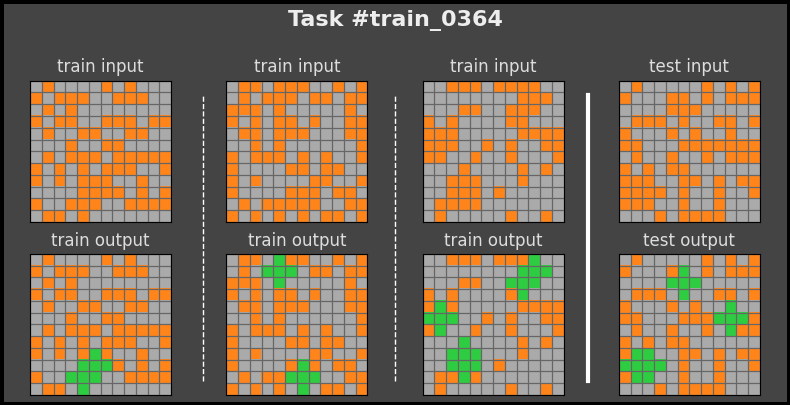

In [10]:
task_id, task = sample_arc_task(train_data, split=None)

test_output = task["test"][0]["output"] if "output" in task["test"][0].keys() else None

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9
)

In [8]:
%%time 

expected_shape = get_grid_shape(test_output)

out = model.solve(
    task=task, 
    expected_rows=expected_shape[0],
    verbose=True
)

out

[INFO] Input and output shapes are identical in all pairs
[INFO] Solving with LLM...
[INFO] Expected shape: (17, 25)
[INFO] Completion time: 0.0000 seconds
CPU times: user 2.21 ms, sys: 1.84 ms, total: 4.05 ms
Wall time: 3.03 ms


[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 6, 6, 6, 7, 7, 5, 7, 7, 6, 6, 6, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 6, 7, 7],
 [7, 6, 7, 6, 7, 5, 5, 7, 7, 7, 6, 7, 7, 7, 6, 7, 7, 6, 6, 6, 7, 6, 6, 7, 7],
 [7, 6, 6, 6, 7, 7, 7, 5, 7, 6, 6, 6, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 6, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 6, 6, 7, 7, 6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 7],
 [7, 7, 6, 7, 7, 7, 6, 7, 7, 6, 7, 6, 7, 7, 6, 7, 7, 7, 6, 7, 7, 6, 7, 6, 7],
 [7, 7, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 [7, 6, 6, 6, 7, 7, 6, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7],
 [7, 7, 6, 7, 7, 6, 6, 6, 7, 6, 6, 7, 7, 7, 6, 7, 7, 6, 6, 6, 7, 7, 6, 7, 7],
 [7, 6, 6, 6, 7, 7, 6, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7],
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

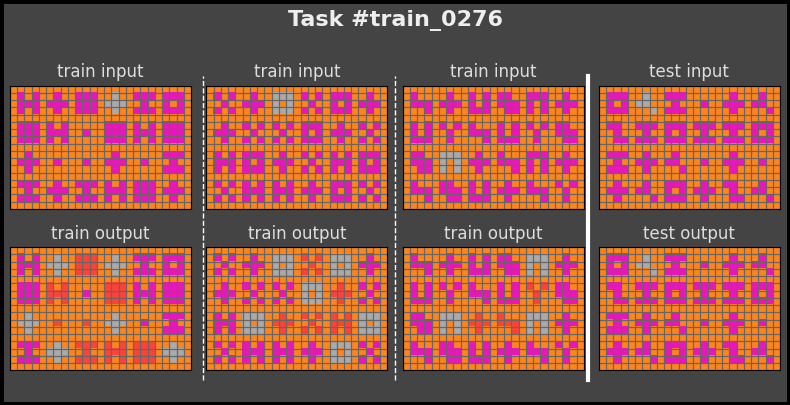

In [9]:
solution = {
    f"{task_id}": out
}

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9,
    task_solutions=solution
)

# Batch Solving

In [10]:
total_match = 0
total_pix_acc = 0
train_preds = []
N = 10

expected_shape = None

for _ in range(N):
    task_id, task = sample_arc_task(train_data, split=None)    
    logger.info(f"{task_id=}")
    
    test_output = task["test"][0]["output"] if "output" in task["test"][0].keys() else None

    if test_output is not None:
        expected_shape = get_grid_shape(test_output)
    
    pred = model.solve(
        task=task, 
        expected_rows=expected_shape[0] if expected_shape else None,
        verbose=True
    )

    solution = {
        f"{task_id}": pred
    }
    
    train_preds.append(solution)

    metrics = model.evaluate(task, [pred])
    match, pix_acc = metrics.values()
        
    total_match+=match
    total_pix_acc+=pix_acc

    print()

avg_acc = total_match/N
avg_pix_acc = total_pix_acc/N

print(f"{avg_acc*100:.5f}% correct matches with {avg_pix_acc*100:.5f}% pixel acc")

[INFO] task_id='train_0607'
[INFO] Input and output shapes are identical in all pairs
[INFO] Solving with LLM...
[INFO] Expected shape: (12, 12)
[WARNING] Generating with a model that requires 14966 MB which is close to the maximum recommended size of 16384 MB. This can be slow. See the documentation for possible work-arounds: https://github.com/ml-explore/mlx-lm/tree/main#large-models
[[6, 7, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7], [5, 7, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7], [6, 7, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7], [6, 7, 6, 6, 6, 6, 6, 6, 7, 5, 5, 5], [2, 7, 2, 2, 2, 2, 2, 2, 7, 5, 5, 5], [2, 7, 2, 2, 2, 2, 2, 2, 7, 5, 5, 5], [2, 7, 7, 7, 7, 7, 2, 2, 2, 5, 5, 5], [2, 7, 7, 7, 7, 7, 2, 2, 2, 7, 7, 7], [5, 7, 7, 7, 7, 7, 5, 5, 5, 7, 7, 7], [5, 7, 5, 5, 5, 7, 5, 5, 5, 7, 7, 7], [5, 7, 5, 5, 5, 7, 5, 5, 5, 7, 7, 7], [5, 7, 5, 5, 5, 7, 5, 5, 5, 7, 7, 7]]
Prompt: 2644 tokens, 120.434 tokens-per-sec
Generation: 433 tokens, 6.604 tokens-per-sec
Peak memory: 16.813 GB
[INFO] Completion time: 94.4061 seconds

[

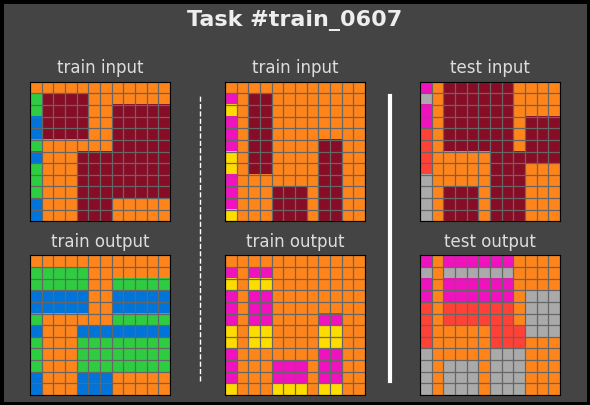

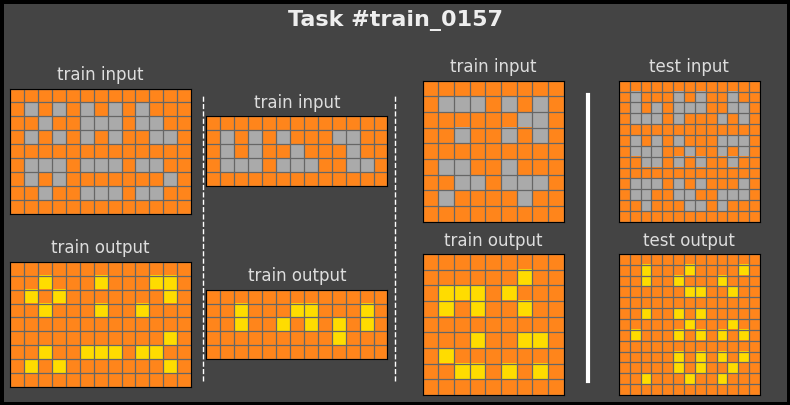

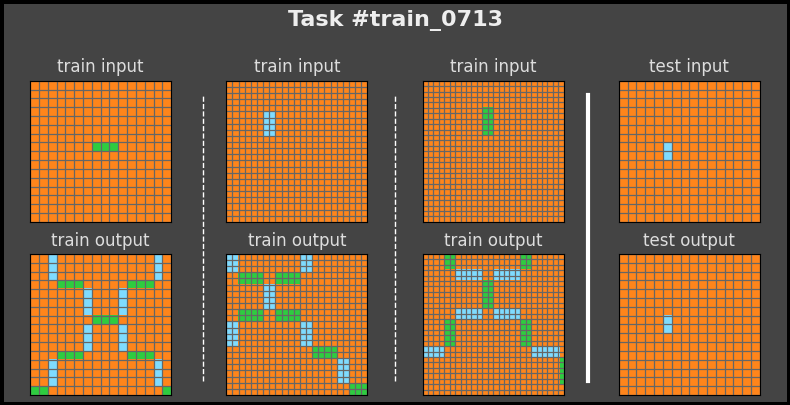

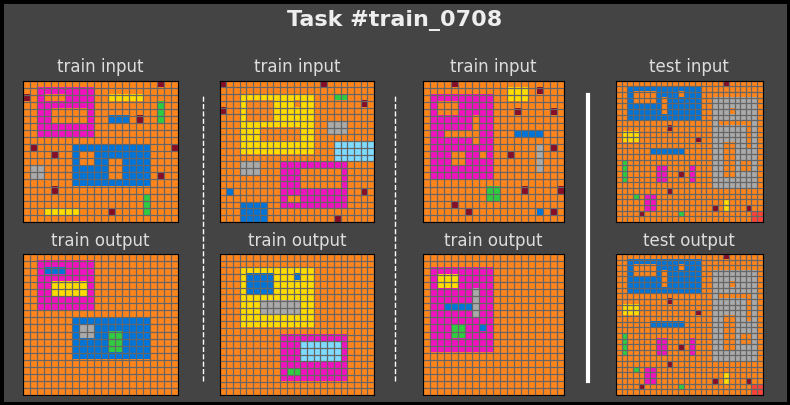

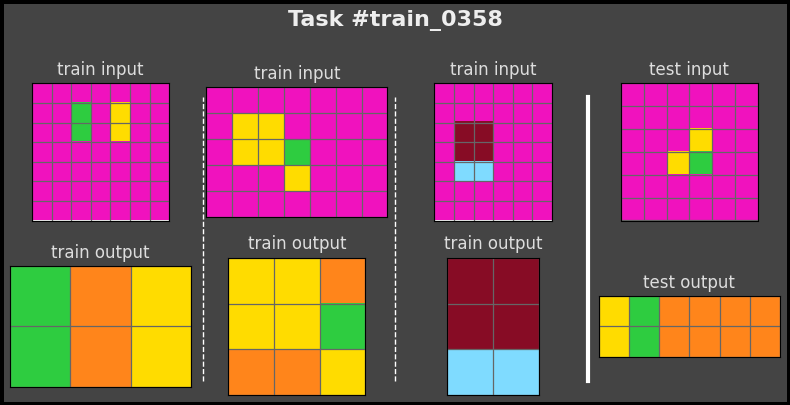

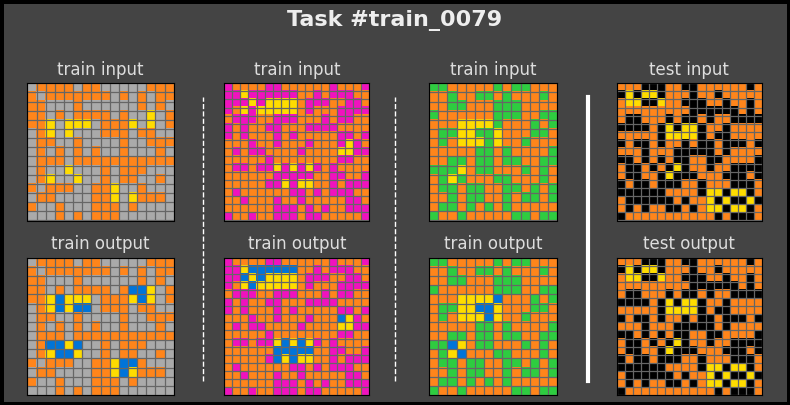

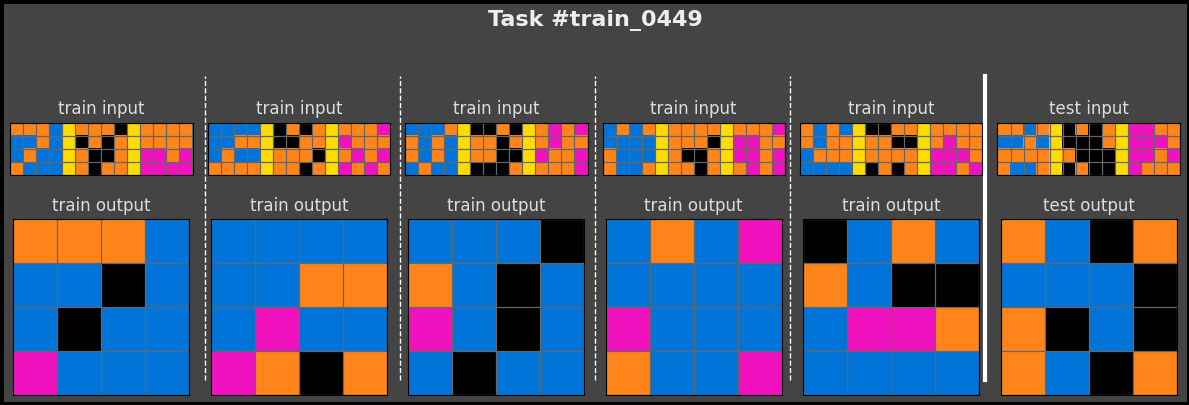

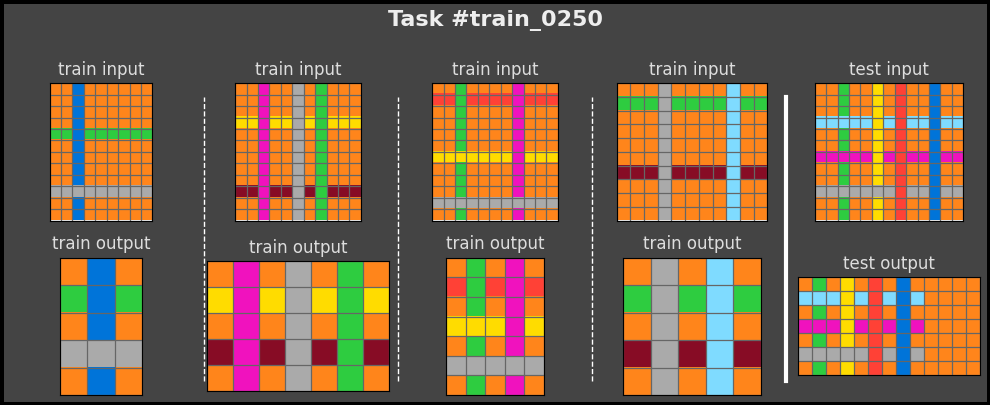

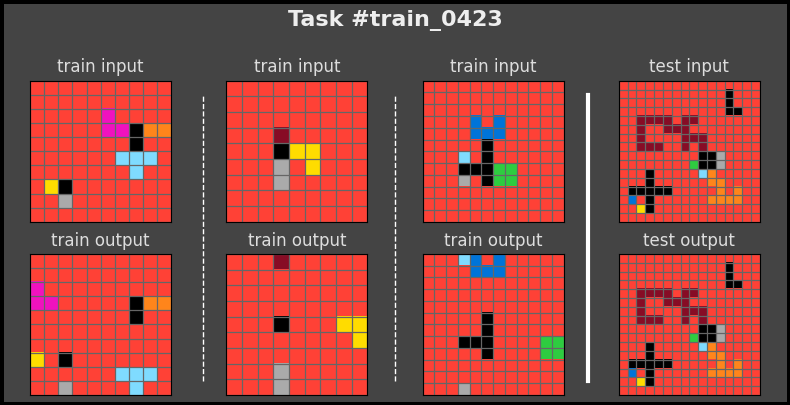

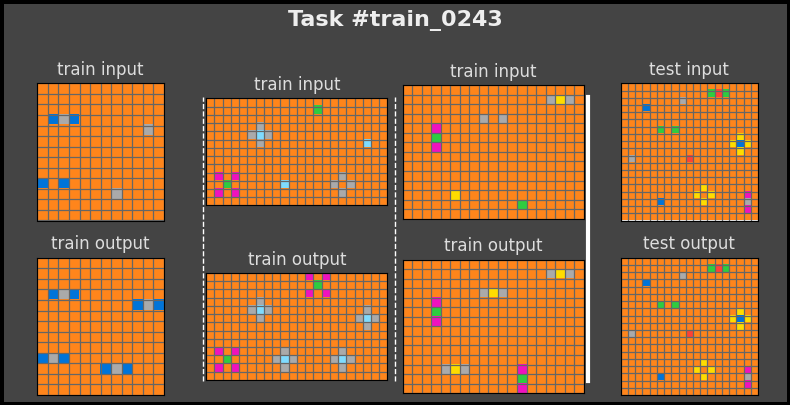

In [11]:
for solution in train_preds:
    task_id = list(solution.keys())[0]
    task = train_data[task_id]
    visualize_task(
        task_data=task,
        task_id=task_id, 
        size=2.0, 
        w1=.9,
        task_solutions=solution
    )

# Predict on Test Set

In [12]:
# Load sample submission to see the format
ss = pd.read_csv(
    osp.join("../", Config.data_path, 'SampleSubmission.csv'),
    dtype={"row": str}
)

print(f"✓ Sample submission has {len(ss)} predictions")

✓ Sample submission has 2303 predictions


In [13]:
test_out_rows = get_row_sizes(ss)
test_out_rows

,ID_,n_rows
0,test_0000,10
1,test_0001,12
2,test_0002,10
3,test_0003,8
4,test_0004,30
...,...,...
180,test_0180,25
181,test_0181,10
182,test_0182,19
183,test_0183,10


In [14]:
test_out_rows.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
n_rows,185.0,12.448649,7.509328,1.0,8.0,10.0,16.0,30.0


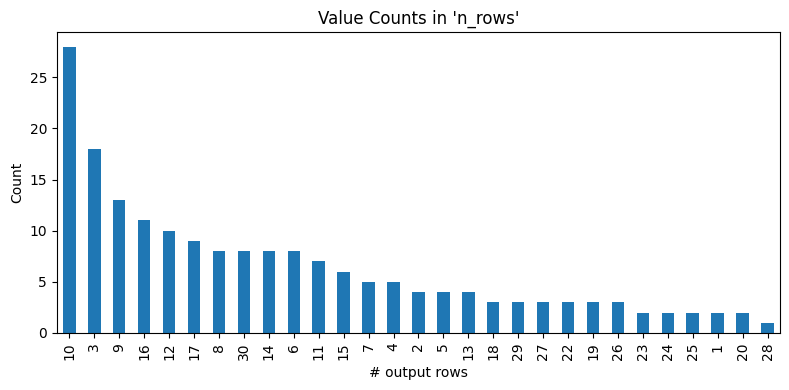

In [15]:
value_counts = test_out_rows["n_rows"].value_counts()

value_counts.plot(kind="bar", figsize=(8, 4))
plt.xlabel("# output rows")
plt.ylabel("Count")
plt.title("Value Counts in 'n_rows'")
plt.tight_layout()
plt.show()

In [16]:
task_id = "test_0003"
n_out_rows = test_out_rows.loc[test_out_rows["ID_"] == task_id, "n_rows"].item()
task = test_data[task_id]
train = task["train"]
test = task["test"][0]

inferred_out_shape = infer_out_shape(
    train_pairs=train, 
    test_input=test["input"],  
    expected_rows=n_out_rows,
    verbose=False
)

pred = model.solve(
    task=task, 
    expected_rows=inferred_out_shape[0],
    verbose=True
) 

[INFO] Input and output shapes are identical in all pairs
[INFO] Solving with LLM...
[INFO] Expected shape: (8, 12)
[WARNING] Generating with a model that requires 14966 MB which is close to the maximum recommended size of 16384 MB. This can be slow. See the documentation for possible work-arounds: https://github.com/ml-explore/mlx-lm/tree/main#large-models
[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4], [7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7], [7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4], [4, 4, 7, 4, 4, 7, 7, 7, 7, 7, 7, 7], [7, 4, 7, 4, 4, 7, 4, 4, 7, 7, 7, 7], [7, 7, 4, 7, 4, 7, 7, 4, 7, 7, 7, 7], [7, 7, 7, 4, 4, 7, 7, 4, 7, 7, 7, 7]]
Prompt: 2224 tokens, 115.699 tokens-per-sec
Generation: 289 tokens, 6.699 tokens-per-sec
Peak memory: 17.042 GB
[INFO] Completion time: 62.6467 seconds


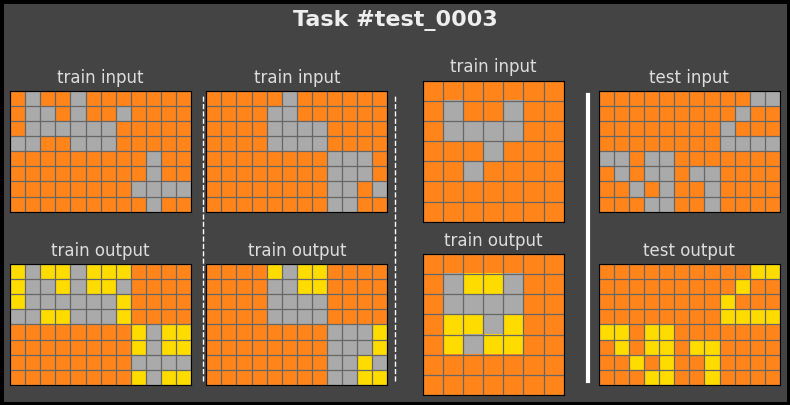

In [17]:
solution = {
    f"{task_id}": pred
}

visualize_task(
    task_data=task,
    task_id=task_id, 
    size=2.0, 
    w1=.9,
    task_solutions=solution
)

# Submission

In [18]:
test_out_rows_sorted = test_out_rows.sort_values(by="n_rows", ascending=False)
test_out_rows_sorted

,ID_,n_rows
161,test_0161,30
36,test_0036,30
22,test_0022,30
74,test_0074,30
167,test_0167,30
...,...,...
143,test_0143,2
54,test_0054,2
108,test_0108,2
169,test_0169,1


In [ ]:
%%time

test_preds = []

for idx, row in tqdm(test_out_rows_sorted.iterrows(), total=len(test_out_rows_sorted)):
    
    task = test_data[row.ID_]
    train = task["train"]
    test = task["test"][0]

    pred = model.solve(
        task=task, 
        expected_rows=row.n_rows,
        verbose=False
    )  

    test_preds.append(pred)


  0%|          | 0/185 [00:00<?, ?it/s]

[WARNING] Generating with a model that requires 14966 MB which is close to the maximum recommended size of 16384 MB. This can be slow. See the documentation for possible work-arounds: https://github.com/ml-explore/mlx-lm/tree/main#large-models
[WARNING] Generating with a model that requires 14966 MB which is close to the maximum recommended size of 16384 MB. This can be slow. See the documentation for possible work-arounds: https://github.com/ml-explore/mlx-lm/tree/main#large-models
[WARNING] Generating with a model that requires 14966 MB which is close to the maximum recommended size of 16384 MB. This can be slow. See the documentation for possible work-arounds: https://github.com/ml-explore/mlx-lm/tree/main#large-models
[WARNING] Generating with a model that requires 14966 MB which is close to the maximum recommended size of 16384 MB. This can be slow. See the documentation for possible work-arounds: https://github.com/ml-explore/mlx-lm/tree/main#large-models
[WARNING] Generating wit

In [ ]:
def sort_K(id_str):
    match = re.match(r"(.*)_(\d+)$", id_str)
    if match:
        task_id, row_num = match.groups()
        return (task_id, int(row_num))
    return (id_str, 0)  # fallback

def generate_submission(
    test_data,
    predictions, 
    expected_rows_list: pd.DataFrame, 
    output_path="submission.csv",
    fill_value=Config.DEFAULT_BG_VALUE
):
    """
    Generates a CSV submission file by solving all test tasks.
    Pads missing rows and sorts by ID before saving.
    """
    assert len(predictions) == len(expected_rows_list), "Mismatch between tasks and expected row counts"

    submission_rows = []
    test_keys = expected_rows_list.ID_.tolist()

    for idx, task_id in enumerate(test_keys):
        expected_rows = expected_rows_list.n_rows.iloc[idx]
        pred = predictions[idx]

        n_cols = len(pred[0]) if pred else expected_rows  # avoid crash on empty predictions

        # Pad missing rows if needed
        while len(pred) < expected_rows:
            pred.append([fill_value] * n_cols)

        # Add to submission
        for row_idx, row in enumerate(pred):
            row_str = "".join(str(cell) for cell in row)
            submission_rows.append((f"{task_id}_{row_idx+1}", row_str))

    # Sort by ID (lexical order)
    submission_rows.sort(key=lambda x: sort_K(x[0]))

    # Write to CSV
    with open(output_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["ID", "row"])
        writer.writerows(submission_rows)

    print(f"Submission saved to {output_path}")

In [ ]:
date_str = datetime.now().strftime("%Y-%m-%d_%H-%M")
sub_filename = f"{date_str}-submission-{Config.model_name}-{Config.experiment}.csv"
out_path = osp.join("..", Config.submission_path, sub_filename)

generate_submission(
    predictions=test_preds, 
    test_data=test_data, 
    expected_rows_list=test_out_rows_sorted, 
    output_path=out_path
)

In [ ]:
submision = pd.read_csv(out_path)
submision

In [ ]:
submision.shape == ss.shape, sum(submision.ID == ss.ID)/ss.shape[0]

In [ ]:
predictions = reconstruct_grids(submision)

In [ ]:
for i in range(10):
    task_id, task_data = sample_arc_task(test_data, split=None)    
    visualize_task(task_data=task_data,task_id=task_id, size=2.0, w1=.9, task_solutions=predictions)